In [1]:
# Ensure openpyxl is updated
# !pip install --upgrade openpyxl

import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
import numpy as np

# Load the data
file_path = "/Users/javadnorouzinia/Downloads/clean_data.xlsx"  # Update this path
df = pd.read_excel(file_path)

# Clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading and trailing whitespace
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
docs = df['cleaned_text'].tolist()

In [2]:
# docs

In [2]:
# Add custom stop words
custom_stop_words = ENGLISH_STOP_WORDS
cust_stop_words = list(custom_stop_words)
# additional_stop_words = {'ipad', 'apple', 'just', 'use', 'great', 'good', 'new'}

# Vectorize the text
vectorizer = CountVectorizer(stop_words=cust_stop_words, max_df=0.95, min_df=2,ngram_range=(1, 3))
X = vectorizer.fit_transform(docs)
features = vectorizer.get_feature_names_out()

# Tokenize documents for gensim coherence model
# tokenized_docs = [doc.split() for doc in docs]
tokenized_docs = [[word for word in doc.split() if word.lower() not in cust_stop_words] for doc in docs]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

Evaluating for 2 topics...
Number of topics: 2, Coherence score: 0.3256, Average intertopic distance: 0.0694
Evaluating for 3 topics...
Number of topics: 3, Coherence score: 0.3172, Average intertopic distance: 0.0886
Evaluating for 4 topics...
Number of topics: 4, Coherence score: 0.3195, Average intertopic distance: 0.0913
Evaluating for 5 topics...
Number of topics: 5, Coherence score: 0.3163, Average intertopic distance: 0.0875
Evaluating for 6 topics...
Number of topics: 6, Coherence score: 0.3221, Average intertopic distance: 0.0841
Evaluating for 7 topics...
Number of topics: 7, Coherence score: 0.3187, Average intertopic distance: 0.0768
Evaluating for 8 topics...
Number of topics: 8, Coherence score: 0.3188, Average intertopic distance: 0.0867
Evaluating for 9 topics...
Number of topics: 9, Coherence score: 0.317, Average intertopic distance: 0.0806
Evaluating for 10 topics...
Number of topics: 10, Coherence score: 0.3143, Average intertopic distance: 0.1051
Evaluating for 11 

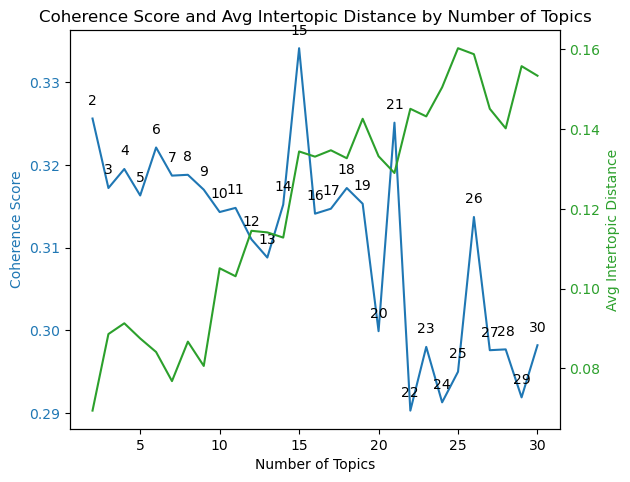

In [3]:
import pyLDAvis.gensim_models as gensimvis
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Function to calculate average intertopic distances and coherence scores
def evaluate_topics(num_topics_list, tokenized_docs, dictionary):
    corpus_gensim = [dictionary.doc2bow(text) for text in tokenized_docs]
    
    evaluation_results = {}
    
    for num_topics in num_topics_list:
        print(f"Evaluating for {num_topics} topics...")
        lda_model_gensim = LdaModel(
            corpus=corpus_gensim, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=10, 
            random_state=42
        )
        
        # Calculate coherence score
        coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()

        vis_data = gensimvis.prepare(lda_model_gensim, corpus_gensim, dictionary)
        
        # Extract topic coordinates
        topic_coordinates = vis_data[0][['x', 'y']].values
        
        # Calculate pairwise distances
        distances = pdist(topic_coordinates, metric='euclidean')
        avg_distance = np.mean(distances)
        
        evaluation_results[num_topics] = {
            'coherence_score': round(coherence_score, 4),
            'avg_intertopic_distance': round(avg_distance, 4)
        }
        print(f"Number of topics: {num_topics}, Coherence score: {round(coherence_score, 4)}, Average intertopic distance: {round(avg_distance, 4)}")
    
    return evaluation_results

# Function to plot evaluation results
def plot_evaluation_results(evaluation_results):
    num_topics = list(evaluation_results.keys())
    coherence_scores = [evaluation_results[k]['coherence_score'] for k in num_topics]
    intertopic_distances = [evaluation_results[k]['avg_intertopic_distance'] for k in num_topics]

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Coherence Score', color=color)
    ax1.plot(num_topics, coherence_scores, color=color, label='Coherence Score')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Annotate the coherence score plot
    for i, txt in enumerate(num_topics):
        ax1.annotate(txt, (num_topics[i], coherence_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Avg Intertopic Distance', color=color)
    ax2.plot(num_topics, intertopic_distances, color=color, label='Avg Intertopic Distance')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Annotate the average intertopic distance plot
    # for i, txt in enumerate(num_topics):
    #     ax2.annotate(txt, (num_topics[i], intertopic_distances[i]), textcoords="offset points", xytext=(0,10), ha='center')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Coherence Score and Avg Intertopic Distance by Number of Topics')
    plt.show()

# Example usage
num_topics_list = list(range(2, 31))  # Generate a list of numbers from 2 to 30

# Tokenize the documents
tokenized_docs = [[word for word in doc.lower().split()] for doc in docs]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(tokenized_docs)

# Evaluate topics
evaluation_results = evaluate_topics(num_topics_list, tokenized_docs, dictionary)

# Plot evaluation results
plot_evaluation_results(evaluation_results)


In [4]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Fit and display topics for selected models
def fit_and_display_lda(num_topics, X, features):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    print(f"Topics for {num_topics} topics model:")
    display_topics(lda, features, num_top_words=15)
    print("\n")
    # print('n_components=', n_components)
    # print('num_topics=', num_topics)

# Evaluate models with 3, 11, 14, and 24 topics
for num_topics in [15]:
    fit_and_display_lda(num_topics, X, features)


Topics for 15 topics model:
Topic 0:
ipad, apple, amazon, screen, service, refund, use, customer service, return, customer, time, tried, restore, did, days
Topic 1:
months, time, ipad, just, use, bought, tried, tablet, app, return, great, device, battery, price, kid
Topic 2:
ipad, new, apple, use, ipads, buy, dont, love, im, years, did, long, old, screen, time
Topic 3:
apple, ipad, keyboard, pencil, apple pencil, screen, smart, smart keyboard, drawing, storage, apps, generation, like, accessories, bought
Topic 4:
ipad, apple, item, like, use, works, new, amazon, work, just, screen, generation, product, does, old
Topic 5:
ipad, screen, great, got, new, set, good, use, tried, took, update, really, unit, bit, year
Topic 6:
ipad, just, apple, product, screen, new, dont, im, power, tried, price, great, work, battery, didnt
Topic 7:
ipad, just, reset, fast, use, factory reset, apple, factory, screen, passcode, ipad just, work, amazon, product, money
Topic 8:
bought, apple, time, ipad, use, d

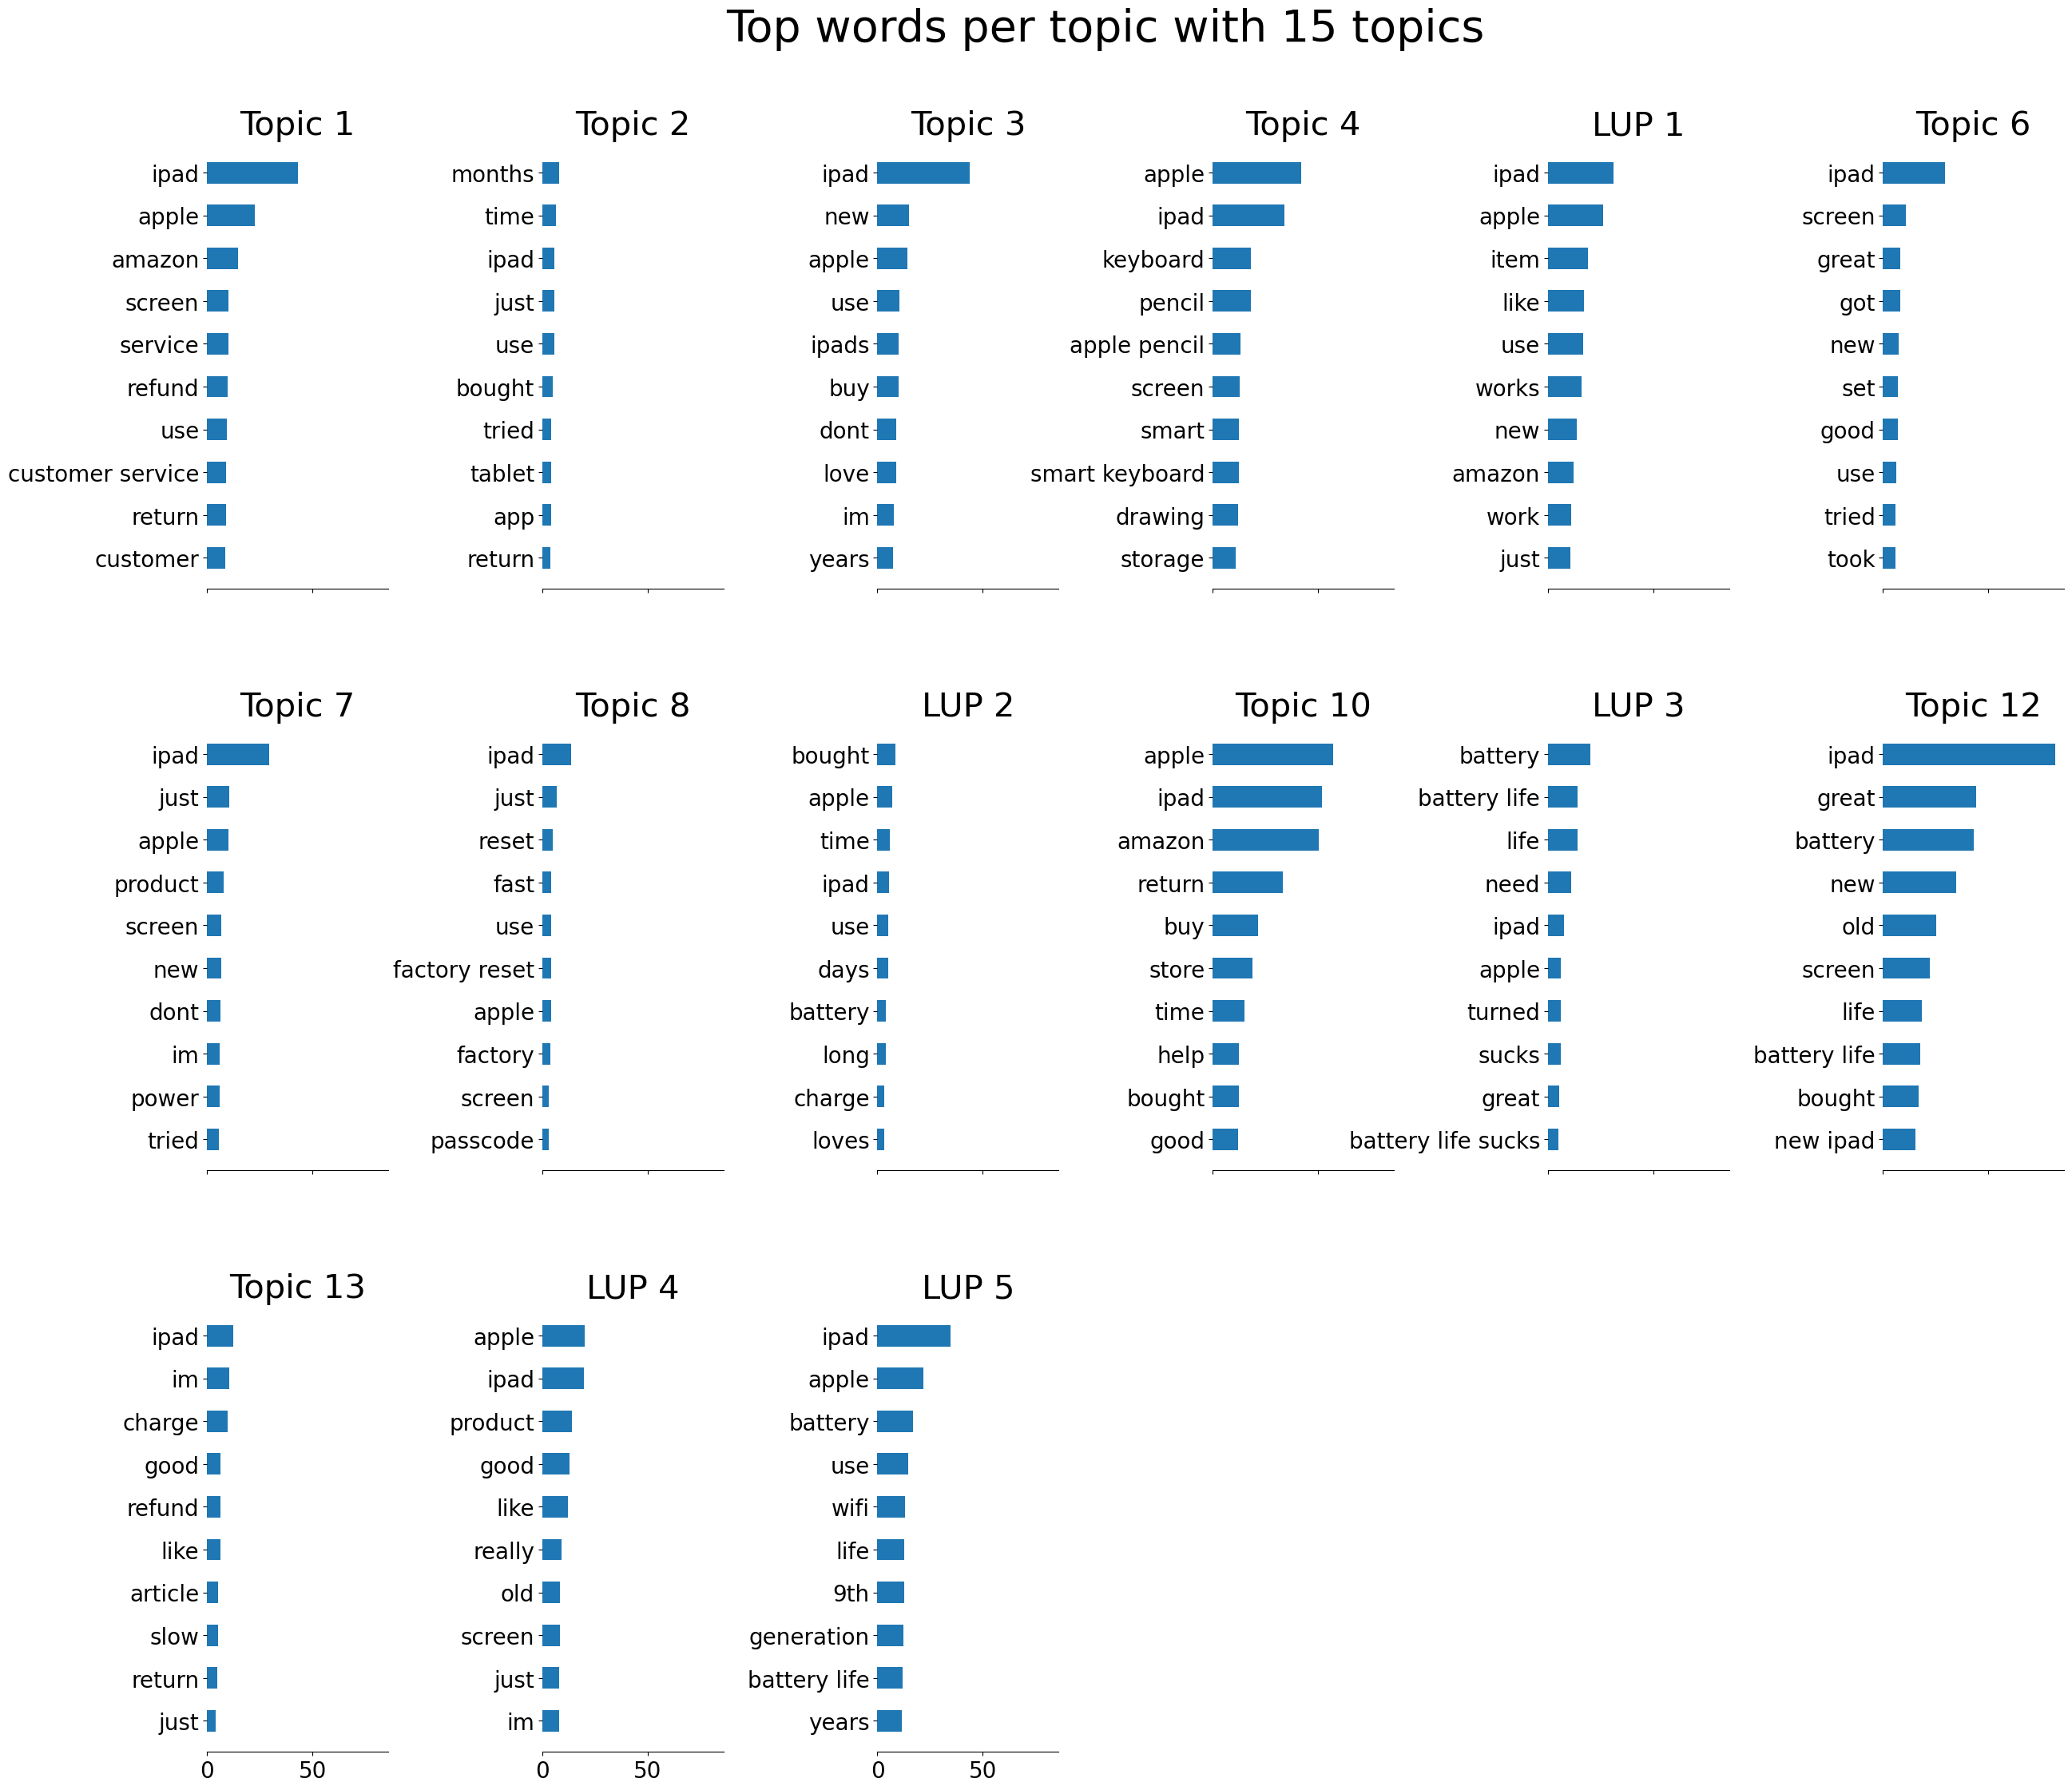

In [27]:
# import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

# Function to plot the top words per topic
def plot_top_words(model, feature_names, num_top_words, title, custom_titles=None):
    num_topics = model.n_components
    num_rows = (num_topics // 6) + (1 if num_topics % 6 != 0 else 0)  # Dynamic row calculation
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 8 * num_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5)
        subplot_title = custom_titles.get(topic_idx, f'Topic {topic_idx}') if custom_titles else f'Topic {topic_idx}'
        ax.set_title(subplot_title, fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    # Remove empty subplots
    for i in range(num_topics, len(axes)):
        fig.delaxes(axes[i])
    fig.suptitle(title, fontsize=40, y=.95)  # Adjusted position of the main title

    plt.subplots_adjust(top=0.88, bottom=0.04, wspace=0.95, hspace=0.3)
    plt.show()

# Function to fit LDA with specified number of topics and plot top words
def fit_and_plot_lda(num_topics_list, X, feature_names, num_top_words, custom_titles_list=None):
    for idx, num_topics in enumerate(num_topics_list):  # Iterate over the list of topic numbers
        model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        model.fit(X)
        # print(f"The number of topics in the model is: {model.n_components}")
        custom_titles = custom_titles_list[idx] if custom_titles_list and idx < len(custom_titles_list) else None
        plot_top_words(model, feature_names, num_top_words, f'Top words per topic with {num_topics} topics', custom_titles)  # Create a separate plot for each number of topics

# Example usage
num_top_words = 10
num_topics_list = [15]  # Specify the list of number of topics you want
custom_titles_list = [
    {0: 'Topic 1',
     1: 'Topic 2',
     2: 'Topic 3',
     3: 'Topic 4',
     4: 'LUP 1',
     5: 'Topic 6',
     6: 'Topic 7',
     7: 'Topic 8',
     8: 'LUP 2',
     9: 'Topic 10',
     10: 'LUP 3',
     11: 'Topic 12',
     12: 'Topic 13',
     13: 'LUP 4',
     14: 'LUP 5'
    }  # Custom titles for the second set of topics
]
fit_and_plot_lda(num_topics_list, X, features, num_top_words, custom_titles_list)


In [19]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

# Function to print representative documents for specific topics
def print_representative_docs(model, X, texts, topics_to_display, num_docs=5):
    doc_topic_distributions = model.transform(X)
    for topic_idx in topics_to_display:
        print(f"Representative reviews for Topic {topic_idx}:")
        topic_docs = [texts[i] for i in np.argsort(doc_topic_distributions[:, topic_idx])[:-num_docs - 1:-1]]
        for doc in topic_docs:
            print(f"  - {doc}")
        print("\n")

# Function to fit LDA and print representative documents
def fit_and_print_representative_docs(num_topics, X, texts, topics_to_display):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    print(f"Representative documents for {num_topics} topics model:")
    print_representative_docs(lda, X, texts, topics_to_display)

# Evaluate model with 15 topics and display specific topics
num_topics = 15
topics_to_display = [4, 8, 10, 13, 14]

fit_and_print_representative_docs(num_topics, X, docs, topics_to_display)


Representative documents for 15 topics model:
Representative reviews for Topic 4:
  - received a new apple ipad to replace an older version we owned found new product to be extremely difficult to setup product would not recognize passwords for setup would not transfer data would not work as a replacement maybe if i had no other apple items and was completely new to apple it may have worked however if you currently own apple products it is a nightmare called apple service for help and they too couldnt make the product work can only surmise that apple products have become just like microsoft very difficult to setup and full of bugs and glitches a real headache for the average consumer to buy and use i am returning this piece of junk and will use our old ipad until we no longer can then will look at alternatives to apple as they are no longer the company i once really liked steve jobs was the secret to apples success tim cook has destroyed apple and it is clearly apparent if you buy any o

In [8]:
num_topics

21

In [19]:
# Function to print representative documents
def print_representative_docs(model, X, texts, num_docs=3):
    doc_topic_distributions = model.transform(X)
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        topic_docs = [texts[i] for i in np.argsort(doc_topic_distributions[:, topic_idx])[:-num_docs - 1:-1]]
        for doc in topic_docs:
            print(f"  - {doc}")

# Function to fit LDA and print representative documents
def fit_and_print_representative_docs(num_topics, X, texts):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    print(f"Representative documents for {num_topics} topics model:")
    print_representative_docs(lda, X, texts)
    print("\n")

# Evaluate models with 3, 11, 14, and 24 topics
for num_topics in [4,8,10,13,14]:
    fit_and_display_lda(num_topics, X, features)
    fit_and_print_representative_docs(num_topics, X, docs)


Topics for 4 topics model:
Topic 0:
ipad, apple, amazon, return, charge, tried, battery, bought, buy, time, use, work, products, just, im
Topic 1:
use, ipad, apple, battery, good, just, time, screen, fast, work, product, life, battery life, bought, tablet
Topic 2:
ipad, new, apple, screen, great, years, old, good, use, generation, battery, price, used, just, ipads
Topic 3:
ipad, apple, like, battery, screen, great, new, bought, old, keyboard, just, dont, pencil, apps, storage


Topics for 8 topics model:
Topic 0:
ipad, apple, amazon, return, tried, days, service, time, use, refund, customer, like, support, customer service, turn
Topic 1:
ipad, time, use, apple, battery, good, wifi, bought, screen, daughter, months, buy, easy, using, old
Topic 2:
ipad, apple, new, generation, 9th generation, 9th, years, use, ipad 9th, ipad 9th generation, product, bought, pencil, used, new ipad
Topic 3:
ipad, apple, battery, great, screen, bought, like, old, pencil, keyboard, new, apps, storage, apple p

In [ ]:
# # Sum the counts of each word
# word_counts = X.toarray().sum(axis=0)

# # Create a DataFrame for the word frequencies
# word_freq = pd.DataFrame({'word': features, 'count': word_counts})

# # Sort the DataFrame by count in descending order
# word_freq = word_freq.sort_values(by='count', ascending=False)

# # Display the top 20 most frequent words
# print(word_freq.head(40))